# Neural Method for Quadratic Energy

## Imports & Intro

This notebook discusses the neural network approach introduced in Zhang et al. and Cabannes et al. for learning eigenfunctions.

In [2]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm
from src.eigensolver.neural.neural_eigensolver import NeuralSolver
from src.energy.quadratic import QuadraticEnergy
from src.energy.gaussian_mixture import GaussianMixture
from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.neural.network.feedforward import FeedForwardNetwork, ConstantFFN, ConstantLinearFFN
from src.eigensolver.neural.loss.orth_loss import BasicOrthogonalityLoss, CovOrthogonalityLoss
from src.eigensolver.neural.loss.variational_loss import VariationalLoss
from torch.utils.data import Dataset, DataLoader
from src.metrics.eigen_evaluator import EigenEvaluator
from src.metrics.reconstruction_evaluator import ReconstructionEvaluator

We are once again solving the eigenfunction problem for the operator $\mathcal{L}$ (see <code>galerkin_quadratic.ipynb</code> for the problem description). The idea of the neural method is to use the following variational formulation for the first $k$ eigenfunctions:
$$\phi = \argmin_{f: \mathbb{R}^d \to \mathbb{R^k}, f_i \perp f_j} \sum_{i=1}^k <f_i, \mathcal{L}f_j>_\mu$$

Thus, the first $k$ eigenfunctions are the set of orthogonal functions which minimize the above variational objective. The basic idea is thus: can we train a neural network to minimize this objective and thereby learn the eigenfunctions? Of course, there is a need for enforcing the orthogonality of eigenfunctions, leading to the following cost function:

$$ \mathcal{R}(f) = \beta \sum_{i=1}^k <f_i, \mathcal{L}f_j>_\mu + \|\mathbb{E}_{x\sim\mu}\left[f(x)f(x)^T\right]- I \|^2$$

While this cost function makes intuitive sense, it is not clear that the minimizers of this objective will coincide with the eigenfunctions, and how the minimizer depends on $\beta$. A result from Cabannes is that the set of minimizers of this objective is given by
$$\argmin_f \mathcal{R} = \left\{U \tilde \phi\ \middle|\ UU^T = I, \tilde\phi_i = \sqrt{\left(1-\frac{\beta}{2}\lambda_i\right)_+}\phi_i\right\}.$$
where $\phi_i$ are the true eigenfunctions. Hence the minimizers of this objective are rescaled and rotated versions of the true eigenfunctions.

In order to obtain the true eigenfunctions and eigenvalues from a minimizer of $\mathcal{R}$, we can use the following approach: assume $f = U\tilde \phi \in \argmin_f \mathcal{R}$ and that $\tilde \phi_i \neq 0$ for all $i$. Then it holds that
$$\mathbb{E}_{x\sim\mu}[f(x)f(x)^T] = U \mathbb{E}_{x\sim\mu}[\tilde \phi(x)\tilde \phi(x)^T]U^T = UDU^T $$
where $D$ is the diagonal matrix $D = I - \frac{\beta}{2}\Lambda$. We do not have exact access to the expectation on the left, but we can estimate it as
$$\frac{1}{N} \sum_{i=1}^N f(x_i)f(x_i)^T, \quad x_i \sim \mu$$
and then perform an eigendecomposition on this matrix to obtain an approximation of $U$ and $D$. Since this matrix can be viewed as the sample covariance matrix of the samples $(f(x_i))_i$, the authors call this a 'PCA-like disentanglement'. Equipped with the matrices $U$ and $D$, we can then reconstruct the eigenfunctions and eigenvalues as
$$\phi = D^{-1/2}U^T f, \quad \Lambda = \frac{2}{\beta}\left(1-D\right)$$

## Demo for $d=2$

### Energy function

As before, we will consider the quadratic energy, whose eigenfunctions and eigenvalues are exactly known.

In [4]:
dim = 2
k = 6
energy = QuadraticEnergy(torch.eye(dim))

### Neural network

We use a simple feed forward neural network with first output constant, which we train using Adam.

In [35]:
model = FeedForwardNetwork([dim,200,200,k])

optimizer = optim.Adam(model.parameters(), lr = 1.0)

Cosine LR scheduling with warmup:

In [36]:
from torch.optim.lr_scheduler import LambdaLR

def combined_scheduler(step, warmup_steps, total_steps, max_lr):
    if step < warmup_steps:
        return max_lr * step / warmup_steps  # Linear warmup
    # Cosine decay after warmup
    progress = (step - warmup_steps) / (total_steps - warmup_steps)
    return max_lr / 2 * (1 + np.cos(np.pi * progress))

warmup_steps = 15
num_epochs = 30
max_lr = 5e-3

scheduler = LambdaLR(optimizer, lr_lambda=lambda step: combined_scheduler(step, warmup_steps, num_epochs, max_lr))

The cost function and training step is defined in the <code>NeuralSolver</code> class:

In [37]:
x = energy.exact_sample((1000000,))

params = {
    'dim': dim,
    'k': k,
    'beta': 0.3,
    'batch_size': 10000,
    'device': 'cuda:1',
    'num_samples': 100000,
}

solver = NeuralSolver(energy, x, model, optimizer, params, scheduler=scheduler)

The following shows a training loop, where we evaluate using the metrics in <code>EigenEvaluator</code>

In [38]:
x_eval = energy.exact_sample((50000,))
evaluator = EigenEvaluator(energy)

metrics = ['eigenvalue_mse','eigenfunc_mse','orth_error','fitted_eigenvalue_mse','eigen_error','fitted_eigen_error']
logged_metrics = np.zeros([num_epochs, len(metrics)+1])

progress_bar = tqdm(range(num_epochs), desc=f"Training: ", leave=True)

for epoch in progress_bar:
    loss = solver.train_epoch()

    solver.compute_eigfuncs() # performs the PCA step

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = params['k'])
    for metric in metrics:
        out[metric] = out[metric][-1]
    out['loss'] = loss
    
    logged_metrics[epoch, 0] = loss
    logged_metrics[epoch, 1:] = [out[metric] for metric in metrics]

    progress_bar.set_postfix(loss=f"{loss:.4f}")

Training: 100%|██████████| 30/30 [02:43<00:00,  5.44s/it, loss=2.1206]


In [25]:
df = pd.DataFrame(logged_metrics, columns = ['loss'] + metrics)

Since we know the exact eigenvalues, we can compute the theoretical minimum loss for our chosen value of $\beta$, and see whether we have reached convergence:

In [24]:
minimizer_norms = torch.sqrt(torch.maximum(torch.zeros(k),1-energy.exact_eigvals(k)*params['beta']/2))

var_loss = torch.sum(params['beta'] * minimizer_norms**2 * energy.exact_eigvals(k))
orth_loss = torch.sum((1-minimizer_norms**2)**2)
opt_loss = var_loss + orth_loss

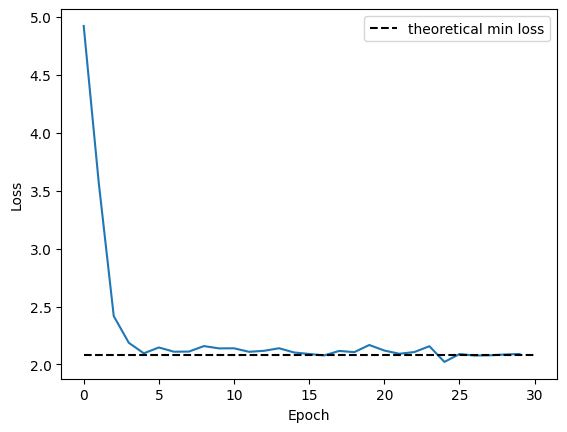

In [28]:
plt.plot(df['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.hlines(opt_loss, 0, len(df), color='black', ls='--', label='theoretical min loss')
plt.legend()

From the above plot, it looks like we are able to reach convergence. Note that deviations can occur because the loss contains expectations which are replaced by finite samples means. We can also investigate the decrease in ground truth metrics:

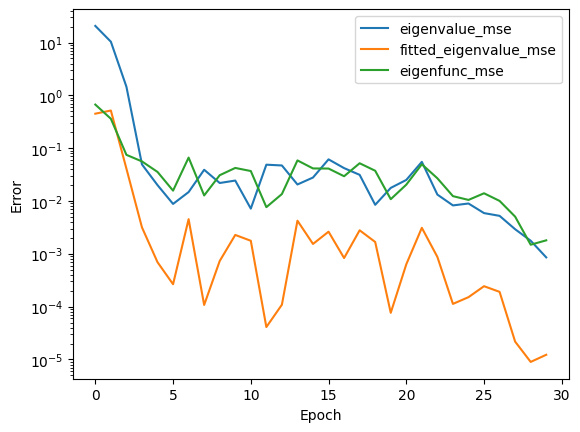

In [33]:
df.loc[:,['eigenvalue_mse','fitted_eigenvalue_mse','eigenfunc_mse']].plot()
plt.xlabel('Epoch') 
plt.ylabel('Error')
plt.yscale('log')
plt.legend()

Finally, we can visualize the learned vs. true eigenfunctions

/home/lclaeys/miniconda3/envs/efs-env/lib/python3.13/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


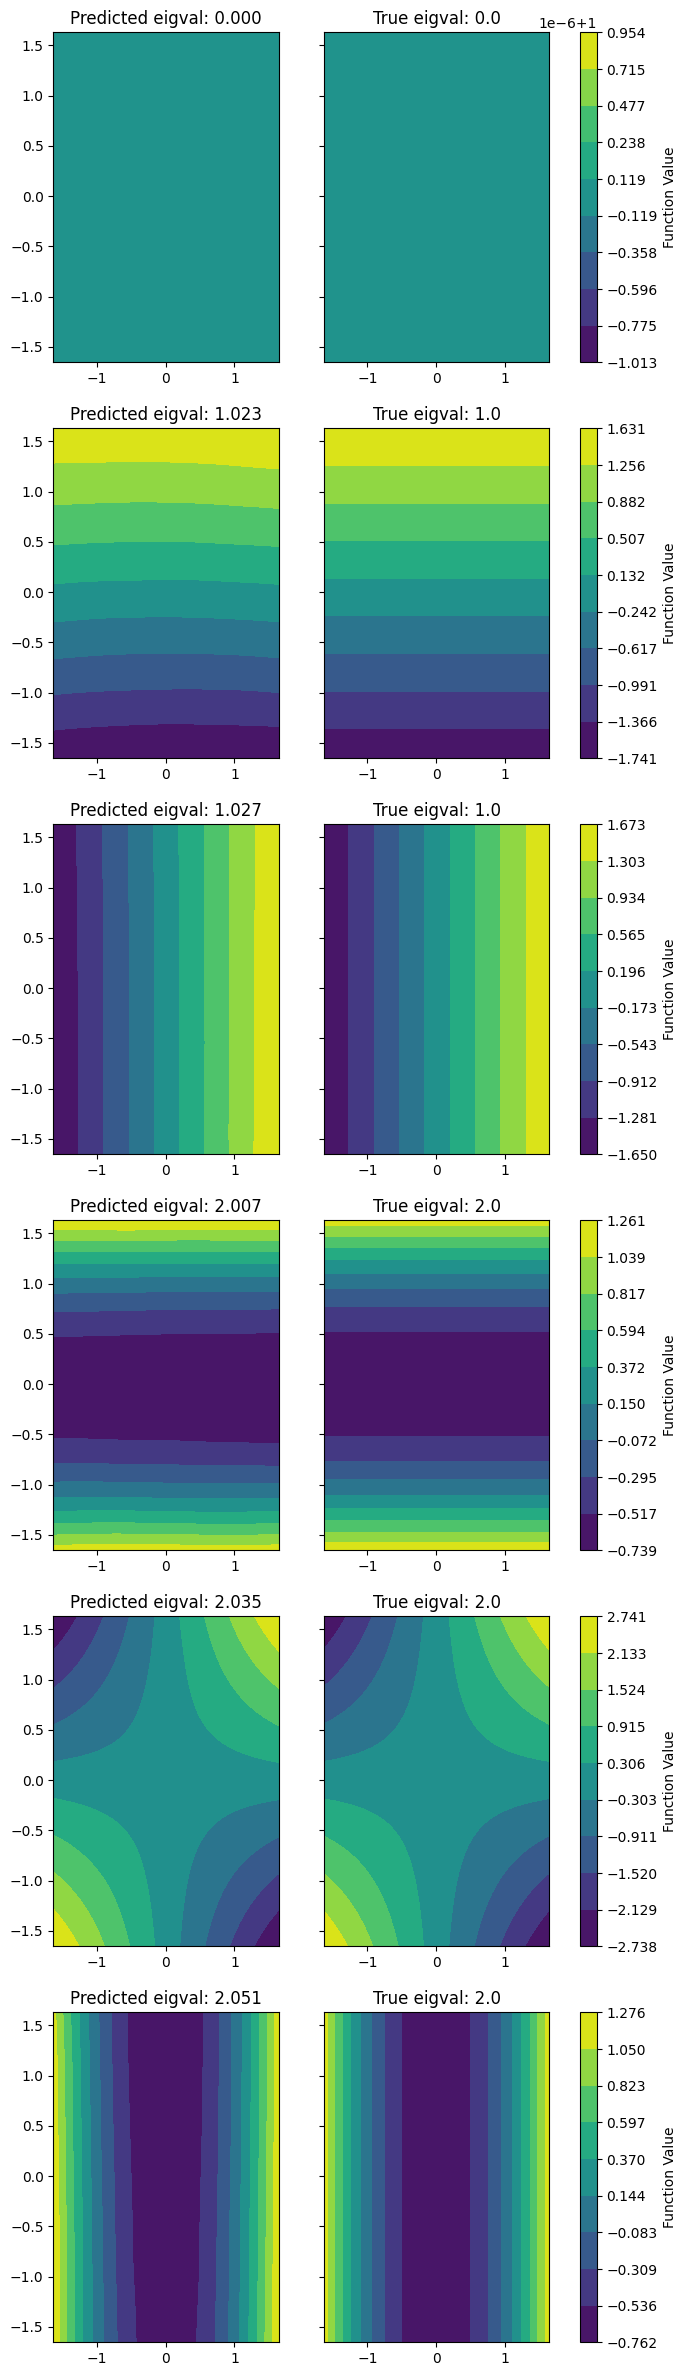

In [34]:
_ = evaluator.plot(solver,x_eval,k,plot_exact=True)